# Feature Extraction
In this notebook, we will carry out tweet bias classification using feature extraction. Specifically, we will make use of a [dataset](https://www.kaggle.com/code/banddaniel/social-media-post-multiclass-classify-w-distilbert?select=political_media_dfe.csv) of tweets containing four columns:

1. `"author"`: The author of the tweet.
2. `"text"`: The text of the tweet.
3. `"bias"`:  The political bias of the tweet. This can be either `"neutral"` or `"partisan"`.
4. `"type"`:  The type of tweet.

We will use the `SentenceTransformer` library to extract features from the text, and then use a `RidgeClassifierCV` to classify the tweets. We will train the classifier on some additional training data (`media_bias_train`) and evaluate it on the test set(`media_bias_test`).

## Environment Setup

In [11]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Install requisite packages
    !pip install sentence_transformers &> /dev/null

    # Change working directory
    %cd /content/drive/MyDrive/LLM4SciSci

In [12]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Feature Extraction
The code begins by loading the data as `pandas.DataFrame` objects.

In [13]:
# Load the data
data = pd.read_csv(
    'science_of_science.csv',
    usecols=['title', 'abstract', 'keywords', 'year', 'citations']
)

# Concatenate titles and abstracts
data['text'] = data['title'] + './n/n' + data['abstract']
data

,title,abstract,keywords,year,citations,text
0,Machine learning misclassification networks reveal a citation advantage of interdisciplinary publications only in high-impact journals,"Given a large enough volume of data and precise, meaningful categories, training a statistical model to solve a classification problem is straightforward and has become a standard application of machine learning (ML). If the categories are not precise, but rather fuzzy, as in the case of scientific disciplines, the systematic failures of ML classification can be informative about properties of the underlying categories. Here we classify a large volume of academic publications using only the abstract as information. From the publications that are classified differently by journal categories and ML categories (i.e., misclassified publications, when using the journal assignment as ground truth) we construct a network among disciplines. Analysis of these misclassifications provides insight in two topics at the core of the science of science: (1) Mapping out the interplay of disciplines. We show that this misclassification network is informative about the interplay of academic disciplines and it is similar to, but distinct from, a citation-based map of science, where nodes are scientific disciplines and an edge indicates a strong co-citation count between publications in these disciplines. (2) Analyzing the success of interdisciplinarity. By evaluating the citation patterns of publications, we show that misclassification can be linked to interdisciplinarity and, furthermore, that misclassified articles have different citation frequencies than correctly classified articles: In the highest 10 percent of journals in each discipline, these misclassified articles are on average cited more frequently, while in the rest of the journals they are cited less frequently. © The Author(s) 2024.",Interdisciplinary research; Machine learning; Maps of science,2024,3,"Machine learning misclassification networks reveal a citation advantage of interdisciplinary publications only in high-impact journals./n/nGiven a large enough volume of data and precise, meaningful categories, training a statistical model to solve a classification problem is straightforward and has become a standard application of machine learning (ML). If the categories are not precise, but rather fuzzy, as in the case of scientific disciplines, the systematic failures of ML classification can be informative about properties of the underlying categories. Here we classify a large volume of academic publications using only the abstract as information. From the publications that are classified differently by journal categories and ML categories (i.e., misclassified publications, when using the journal assignment as ground truth) we construct a network among disciplines. Analysis of these misclassifications provides insight in two topics at the core of the science of science: (1) Mapping out the interplay of disciplines. We show that this misclassification network is informative about the interplay of academic disciplines and it is similar to, but distinct from, a citation-based map of science, where nodes are scientific disciplines and an edge indicates a strong co-citation count between publications in these disciplines. (2) Analyzing the success of interdisciplinarity. By evaluating the citation patterns of publications, we show that misclassification can be linked to interdisciplinarity and, furthermore, that misclassified articles have different citation frequencies than correctly classified articles: In the highest 10 percent of journals in each discipline, these misclassified articles are on average cited more frequently, while in the rest of the journals they are cited less frequently. © The Author(s) 2024."
1,Dynamic patterns of the disruptive and consolidating knowledge flows in Nobel-winning scientific breakthroughs,"Scientific breakthroughs possess the transformative potential to reshape researc

Note the considerable number of training samples. The code then next initializes the `SentenceTransformer` model `'all-mpnet-base-v2'` and extracts features from the training data using the `encode` method. 

In [14]:
# Initialize feature extraction pipeline
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extract features
features = model.encode(data['text'], show_progress_bar=True)
features

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

array([[-0.00473206, -0.04576412,  0.01965012, ..., -0.03477446,
         0.02810462,  0.01813718],
       [-0.05819887, -0.06011161,  0.02259039, ..., -0.06635984,
         0.05790947,  0.03990703],
       [-0.06759556,  0.02921594, -0.0322248 , ...,  0.00199628,
         0.01664495, -0.01207595],
       ...,
       [ 0.02056852,  0.00477816, -0.08616947, ...,  0.10622985,
         0.02579156, -0.02725776],
       [ 0.00344623,  0.02273844, -0.06633328, ...,  0.01183059,
        -0.0287214 ,  0.07119869],
       [-0.05497676,  0.01687015, -0.01583676, ..., -0.051455  ,
         0.03415811, -0.0143118 ]], dtype=float32)

In [15]:
tsne_3d = TSNE(n_components=3, random_state=42)
features_3d = tsne_3d.fit_transform(features)
features_3d

array([[-39.34816  ,   6.117009 , -10.931155 ],
       [-25.803839 ,   1.3947022, -16.234304 ],
       [ -2.207882 ,  11.289228 , -22.565681 ],
       ...,
       [ 33.166267 , -13.272928 ,   7.1375747],
       [  1.8071437,   3.9425175, -10.591645 ],
       [ 34.78501  ,  -0.4610935, -14.247688 ]], dtype=float32)

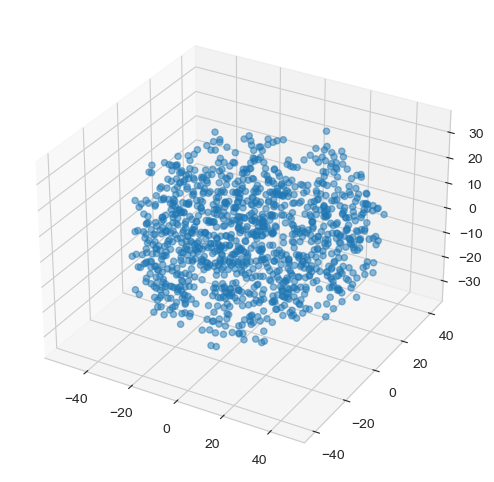

In [16]:
# Plot features using scatterplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], alpha=.5)
plt.show()

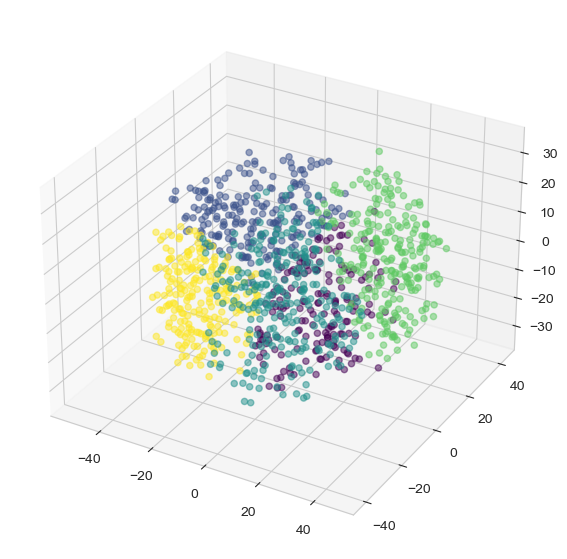

In [17]:
# Cluster using KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(features_3d)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
    c=kmeans.labels_, cmap="viridis", alpha=.5
)

In [18]:
# Saving the clusters as a new column
data['cluster'] = pd.Series(kmeans.labels_, dtype=str)

# Extract keywords counts by cluster
cluster_keyword_counts = {}
unique_keywords = set()
for cluster in data['cluster'].unique():
    cluster_data = data.query('cluster == @cluster')
    keywords = cluster_data['keywords'].str.cat(sep='').split(';')
    keywords = [keyword.strip().lower() for keyword in keywords]  # Remove punctuation, trim, lowercase
    keywords = list(filter(None, keywords))

    unique_keywords = unique_keywords.union(set(keywords))

    keyword_counts = Counter(keywords)
    cluster_keyword_counts[cluster] = {keyword.strip().lower(): count for keyword, count in keyword_counts.items()}

# Building cluster-keyword count matrix
count_matrix = pd.DataFrame(
    index=cluster_keyword_counts.keys(), columns=list(unique_keywords)
)
for cluster in count_matrix.index:
    for keyword in count_matrix.columns:
        count_matrix.loc[cluster, keyword] = cluster_keyword_counts[cluster].get(keyword, 0)


count_matrix = count_matrix.astype(int) # Convert to int format
count_matrix = count_matrix.loc[:, count_matrix.sum() > 3] # Drop keywords occuring <=3 times
count_matrix

,science of science,citation networks,questionable research practices,peer review,research policy,network science,knowledge management,replication,bibliometrics,collaboration,...,open data,high-skilled migration,big data,innovation,scientific impact,respiratory muscles,nobel prize,incentives,cultural evolution,ontology
4,97,1,0,2,2,4,1,1,2,2,...,0,4,3,7,5,0,5,1,1,1
0,21,0,0,0,1,0,0,1,2,3,...,1,0,0,2,1,0,0,0,0,1
2,15,0,8,7,0,0,1,30,1,0,...,12,0,0,0,0,4,0,2,3,0
1,45,5,0,1,1,4,1,0,4,0,...,0,0,2,8,1,0,0,1,1,3
3,20,0,2,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [19]:
def compute_pmi(df):
    mat = df.to_numpy(dtype=np.float64)  # Convert DataFrame to NumPy array
    p = mat / np.sum(mat)  # Compute probability matrix

    row_sums = np.sum(p, axis=1, keepdims=True) ** 0.7  # Compute row sums raised to power 0.7
    col_sums = np.sum(p, axis=0, keepdims=True)  # Compute column sums

    expected = row_sums @ col_sums  # Outer product of row and column sums
    pmi = p / expected  # Compute PMI matrix

    return pd.DataFrame(pmi, index=df.index, columns=df.columns)


# Compute PPMI
tfidf_matrix = compute_pmi(count_matrix)
tfidf_matrix

,science of science,citation networks,questionable research practices,peer review,research policy,network science,knowledge management,replication,bibliometrics,collaboration,...,open data,high-skilled migration,big data,innovation,scientific impact,respiratory muscles,nobel prize,incentives,cultural evolution,ontology
4,1.339824,0.455816,0.000000,0.497254,1.367449,1.367449,0.683724,0.085466,0.546980,1.093959,...,0.000000,2.734898,1.640939,1.126134,1.953499,0.000000,2.734898,0.683724,0.546980,0.455816
0,0.490878,0.000000,0.000000,0.000000,1.157069,0.000000,0.000000,0.144634,0.925655,2.776966,...,0.330591,0.000000,0.000000,0.544503,0.661182,0.000000,0.000000,0.000000,0.000000,0.771380
2,0.155992,0.000000,1.647279,1.310336,0.000000,0.000000,0.514775,1.930405,0.205910,0.000000,...,1.764942,0.000000,0.000000,0.000000,0.000000,2.059099,0.000000,1.029550,1.235459,0.000000
1,0.723510,2.652871,0.000000,0.289404,0.795861,1.591723,0.795861,0.000000,1.273378,0.000000,...,0.000000,0.000000,1.273378,1.498092,0.454778,0.000000,0.000000,0.795861,0.636689,1.591723
3,0.496625,0.000000,0.983317,0.446962,0.000000,0.000000,1.229146,0.000000,0.491659,0.000000,...,0.351185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.819431


In [20]:
# Get top 5 highest-PMI keywords
top_keywords = tfidf_matrix.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
top_keywords

4        [disruption, nobel prize, novelty, high-skilled migration, computational social science]
0                 [data analytics, collaboration, diversity, meta science, science communication]
2    [randomized clinical trials, replicability, monitoring, open materials, cross-fertilization]
1             [topic detection, knowledge graphs, text mining, scholarly data, citation networks]
3              [knowledge, epistemology, history of science, neuroscience, philosophy of science]
dtype: object


The features are then standardised before being fed into `RidgeClassifierCV`. This is crucial, since `RidgeClassifierCV` uses l2 (ridge) regularisation to prevent over-fitting, which assumes that the features have the same scaling. The classifier is then trained on the training data using the `fit` method. Note that `RidgeClassifierCV` will automatically perform cross-validation on the training data to find the best alpha value from the list of `alphas` provided. Performance on the training data is then evaluated using the `score` method.

In [21]:
features = pd.DataFrame(features)
features['age'] = data['year'].max() - data['year']
features.columns = [str(name) for name in features.columns]

X_train, X_test, y_train, y_test = train_test_split(
    features, np.log1p(data['citations']), test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Initialize classifier
ridge = RidgeCV(alphas=np.logspace(-10, 10, 100))

# Train classifier
ridge.fit(X_train, y_train)
f"Train accuracy: {ridge.score(X_train, y_train):.2f}"

'Train accuracy: 0.29'

Features are next extracted for the test set and standardised using the same `StandardScaler` object that was fitted on the training data to prevent data leakage. The classifier is then evaluated on the test data using the `score` method.

In [22]:
# Standardising features
X_test = scaler.transform(X_test)

# Test classifier
f"Test accuracy: {ridge.score(X_test, y_test):.2f}"

'Test accuracy: 0.06'


**TASK 1:** Go to the `SentenceTransformers` [model page](https://sbert.net/docs/sentence_transformer/pretrained_models.html) and find a well-performing model of similar size to  `'all-mpnet-base-v2'`. Open the Hugging Face model card by clicking on the model name and then the link next to 'Model Card'. Replace the `"all-mpnet-base-v2"` in the code above with the models name (make sure to copy the full name by clicking on the copy-icon to the right of the name at the top of the page). Re-run the analysis. Does the performance improve?

**TASK 2 (BONUS):** Consider how you might apply the above methods in your own research. If you have dataset in mind, try uploading it to the repository in your Google Drive and loading it into this notebook to run the analysis with your own data (**Caution**: make sure you don't delete the original `science_of_science.csv` dataset, as we will need it for the next exercise).

